# Mini Project 2 - ece481-01
Tyler Rarick

In [1]:
import IPython.display as ipd # For in-notebook audio
import numpy as np           # Nice data structures and math operations
import pandas as pd
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Song:
    
    def __init__(self, fs=44100, fref=440, bpm=120):
        self.fs = fs
        self.fref= fref
        self.bpm = bpm
        self.df = pd.DataFrame(columns=['start', 'note',
                                        'duration', 'intensity'])  
        return
        
    def __BarToSamples(self):
        return int(self.__BarToSeconds()*self.fs)
    
    def __BarToSeconds(self):
        return 4*(1/self.bpm)*60
    
    def __NoteToFreq(note, fref):
        return fref*np.power(2, note/12)
    
    # Duration and start in bars
    def AddNote(self, start, note, duration=0.25, intensity=0.1):
        newNote = pd.DataFrame([[start, note, duration, intensity]],
                                columns=['start', 'note',
                                         'duration', 'intensity'])
        
        self.df = self.df.append(newNote)
        return
                
        # TODO: Implement
#     def MajorToNote(self):
#         return
    
    def Compile(self, instrument):    
        df = self.df.copy()
        barSamples = self.__BarToSamples()
        arraySize = (df['start'] + df['duration']).max()*barSamples
        arraySize = np.ceil(arraySize).astype(np.int) + 1
        
        x = np.zeros(arraySize)
        
        df['note'] = df['note'].apply(Song.__NoteToFreq, args=(self.fref,))
        df['start'] = df['start']*barSamples
        df['duration'] = df['duration']*self.__BarToSeconds()
        
        for i, note in df.iterrows():
            subArray = instrument.play(note['note'], 
                                       self.fs,
                                       note['duration'],
                                       note['intensity'])
            start = np.floor(note['start']).astype(np.int)
            end = start + subArray.size
                        
            x[start:end] += subArray
            
        return 0.5*x/max(x)

In [19]:
class Instrument(object):
    
    def __init__(self, envelope=None):
        # Envelope defined in tuples of ADSR, (dB, Time)
        # Units are dB and seconds
        self.__envelope = envelope
        if self.__class__ == Instrument:
            raise NotImplementedError
        
    # Duration in seconds
    def play(self, f, fs, duration, intensity):
        # If no envelope, just return playFunc
        if self.__envelope is None:
            return self.playFunc(f, fs, duration, intensity)
        
        # If there is an envelope, apply it.
        else:
            env = Instrument.__CompileEnvelope(self.__envelope, fs)
            x = self.playFunc(f, fs, duration, intensity)
            return Instrument.__ApplyEnvelope(x, env)
        
#     def __playFunc(self, f, fs, duration, intensity):
#         if self.__class__ == Instrument:
#             raise NotImplementedError        
            
            
    def __CompileEnvelope(envelope, fs):
        if(len(envelope) != 4):
            raise ValueError('Envelope size must be 4: ADSR')
            
        times, amps = zip(*envelope)
        
        xvals = np.linspace(0, times[-1], fs*times[-1])
        env = np.interp(xvals, times, amps)
        
        return np.power(10, env/20)
        
        
    def __ApplyEnvelope(x, envelope):
        env = np.zeros(x.shape)
        
        maxBound = min(len(envelope), env.shape[0])
        
        env[0:maxBound] = envelope[0:maxBound]
        
        return env*x
        
                
    def OscillatorView(self):
        return self.playFunc(1, 100, 1, 1)

In [20]:
class SineWave(Instrument):

    # Duration in seconds
    def playFunc(self, f, fs, duration, intensity):
        samples = fs*duration
        t = np.linspace(0,duration, samples)

        w = 2*np.pi*f
        
        return intensity*np.sin(w*t)

In [21]:
class SawTooth(Instrument):
    
    # Duration in seconds
    def playFunc(self, f, fs, duration, intensity):
        samples = fs*duration
        t = np.linspace(0,duration, samples)
        
        T = 1/f
        
        # t mod T represents progress to T
        # Amplitude scaled by /T*intensity
        return intensity*(t % T)/T

In [22]:
class SquareWave(Instrument):
    
    # Duration in seconds
    def playFunc(self, f, fs, duration, intensity):
        samples = fs*duration
        t = np.linspace(0,duration, samples)
        
        T = 1/f
        
        # Same as Sawtooth but rounded to integer 0/1
        return intensity*np.round((t % T)/T)

In [23]:
class TriangleWave(Instrument):
    
    # Duration in seconds
    def playFunc(self, f, fs, duration, intensity):
        samples = fs*duration
        t = np.linspace(0,duration, samples)
        
        T = 1/f
        
        # 2*abs(square wave - sawtooth)
        return 2*intensity*abs(np.round((t % T)/T) - (t % T)/T)

In [24]:
class Snare(Instrument):
    def playFunc(self, f, fs, duration, intensity):
        
        x = np.random.rand(np.ceil(fs*duration).astype(np.int))
        
        wp = (f / fs)
        ws = 3/4*(f / fs)
        rp = 3
        rs = 30
        order, wn = sig.cheb1ord(wp, ws, rp, rs)
        
        b, a = sig.cheby1(order, rp, wn, btype='low')
        
        return sig.lfilter(b, a, x)

In [25]:
song = Song(fs=44100, fref=440, bpm=120)
song.AddNote(0, 0, duration=2)
song.AddNote(0.25, 2, duration=1/4)
song.AddNote(0.5, 4, duration=3/2)
song.AddNote(0.75, 5, duration=1/4)
song.AddNote(1, 7, duration=1)
song.AddNote(1.25, 9, duration=1/4)
song.AddNote(1.5, 11, duration=1/4)
song.AddNote(1.75, 12, duration=1/4)

song.AddNote(2, 12-12, duration=1/4)
song.AddNote(2.25, 11-12, duration=1/4)
song.AddNote(2.5, 9-12, duration=1/4)
song.AddNote(2.75, 7-12, duration=13/4)
song.AddNote(3, 5-12, duration=1/4)
song.AddNote(3.25, 4-12, duration=11/4)
song.AddNote(3.5, 2-12, duration=1/4)
song.AddNote(3.75, 0-12, duration=9/4)
song.AddNote(3.75, 0-24, duration=9/4)

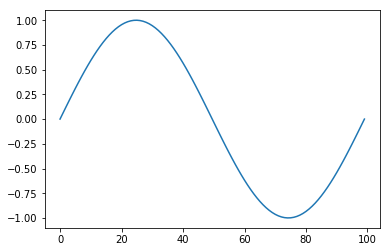

In [26]:
inst = SineWave([(0, -60), (0.1, 0), (0.5,-3), (3, -60)])
x = song.Compile(inst)
plt.plot(inst.OscillatorView())
ipd.Audio(x, rate=song.fs)

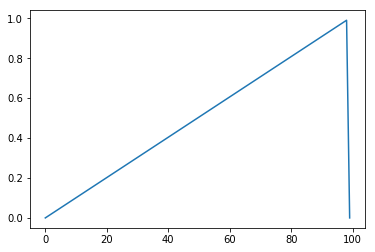

In [27]:
inst=SawTooth([(0, -60), (0.1, 0), (0.5,-3), (3, -60)])
x = song.Compile(inst)
plt.plot(inst.OscillatorView())
ipd.Audio(x, rate=song.fs)

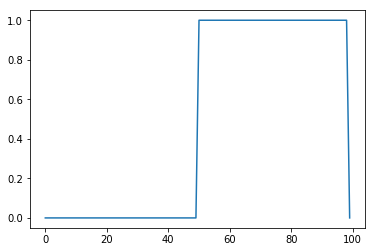

In [28]:
inst=SquareWave([(0, -60), (0.1, 0), (0.5,-3), (3, -60)])
x = song.Compile(inst)
plt.plot(inst.OscillatorView())
ipd.Audio(x, rate=song.fs)

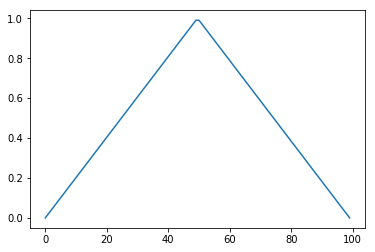

In [13]:
inst=TriangleWave([(0, -60), (0.1, 0), (0.5,-3), (3, -60)])
x = song.Compile(inst)
plt.plot(inst.OscillatorView())
ipd.Audio(x, rate=song.fs)

In [14]:
drumSong = Song(fs=44100, fref=440, bpm=160)
for i in range(32):    
    if(i%4 == 2):
        drumSong.AddNote(i*0.125, 72, duration=1/64)
        
    else:
        drumSong.AddNote(i*0.125, -18, duration=1/32)


In [15]:
d = drumSong.Compile(instrument=Snare())
ipd.Audio(d, rate=drumSong.fs)

In [16]:
# 2C, 70 bpm
trianglePart = Song(fs=44100, fref=261.62/2, bpm=70)

# First chord
trianglePart.AddNote(0, 0, duration=1)
trianglePart.AddNote(0, 7, duration=1)
trianglePart.AddNote(0, 11, duration=1)
trianglePart.AddNote(0, -12, duration=1)

# Second chord
trianglePart.AddNote(1, -3, duration=1)
trianglePart.AddNote(1, 5, duration=1)
trianglePart.AddNote(1, 10, duration=1)
trianglePart.AddNote(1, 17, duration=1)

# Third chord
trianglePart.AddNote(2, -5, duration=1)
trianglePart.AddNote(2, 2, duration=1)
trianglePart.AddNote(2, 5, duration=1)
trianglePart.AddNote(2, 11, duration=1)

# Fourth chord
trianglePart.AddNote(3, -7, duration=1)
trianglePart.AddNote(3, 0, duration=1)
trianglePart.AddNote(3, 3, duration=1)
trianglePart.AddNote(3, 9, duration=1)

In [17]:
# 2C, 70 bpm
squarePart = Song(fs=44100, fref=261.62, bpm=70)

squarePart.AddNote(1/4+1/16, 2, duration=1/16)
squarePart.AddNote(1/4+2/16, 0, duration=1/16)
squarePart.AddNote(1/4+3/16, 2, duration=1/16)
squarePart.AddNote(1/4+4/16, 4, duration=2/16)
squarePart.AddNote(1/4+6/16, 4, duration=2/16)
squarePart.AddNote(1/4+8/16, 4, duration=1/16)
squarePart.AddNote(1/4+9/16, 2, duration=1/16)
squarePart.AddNote(1/4+10/16, 0, duration=1/16)

#
squarePart.AddNote(1+10/16, 7, duration=1/32)
squarePart.AddNote(1+10/16+1/32, 9, duration=3/32)
squarePart.AddNote(1+10/16+4/32, 7, duration=2/32)

#
for k in range(7):
    squarePart.AddNote(2+1/2+k*1/16, 11, duration=1/32)

squarePart.AddNote(2+1/2+7/16, 11, duration=1/16)

#
squarePart.AddNote(3, 5, duration=1/4)
squarePart.AddNote(3+1/4, 4, duration=1/4)
squarePart.AddNote(3+2/4, 0, duration=1/4)

## Part 3

In [18]:
x = trianglePart.Compile(instrument=TriangleWave())
s = squarePart.Compile(instrument=SquareWave())

x[0:s.size] += 1/16*s

ipd.Audio(x, rate=squarePart.fs)